# Seminar 1: Autoencoders

In this notebook, we will explore:
1. Simple Autoencoder (AE)
2. Denoising Autoencoder (DAE)
3. Sparse Autoencoder (SAE)

We will use MNIST data, resized to 64x64. We will observe:
- How the latent space evolves during training
- Reconstructions of images
- Generation of new (albeit simple) samples by sampling latent space

In [1]:
import torch
from torch import nn
from torch.nn import functional as F
import matplotlib.pyplot as plt
import numpy as np

from tqdm.auto import tqdm
from sklearn.manifold import TSNE

%matplotlib inline


## Data Loading and Preparation

We use `torchvision.datasets.MNIST` with the transform that resizes images to 64x64 and converts them to tensors. 

**Best Practice:** 
- Keep an eye on normalization. Here, we do not strictly require a `[0,1]` or `[-1,1]` normalization, because MNIST is already in the `[0,1]` range. But if you were dealing with other data, you might want to add `transforms.Normalize(...)`.


In [2]:
from torchvision.datasets import MNIST
from torchvision import transforms
from torch.utils.data import DataLoader

/Users/kgb/opt/miniforge3/envs/py311_dgm/lib/python3.11/site-packages/torchvision/io/image.py:13: UserWarning: Failed to load image Python extension: 'dlopen(/Users/kgb/opt/miniforge3/envs/py311_dgm/lib/python3.11/site-packages/torchvision/image.so, 0x0006): Symbol not found: __ZN3c1017RegisterOperatorsD1Ev
  Referenced from: <CFED5F8E-EC3F-36FD-AAA3-2C6C7F8D3DD9> /Users/kgb/opt/miniforge3/envs/py311_dgm/lib/python3.11/site-packages/torchvision/image.so
  Expected in:     <8E6D6BF5-9658-33B9-9D3C-DF587B2F99E7> /Users/kgb/opt/miniforge3/envs/py311_dgm/lib/python3.11/site-packages/torch/lib/libtorch_cpu.dylib'If you don't plan on using image functionality from `torchvision.io`, you can ignore this warning. Otherwise, there might be something wrong with your environment. Did you have `libjpeg` or `libpng` installed before building `torchvision` from source?
  warn(


In [3]:
mnist_transforms = transforms.Compose([
    transforms.Resize((64, 64)),
    transforms.ToTensor()
])

In [4]:
device: str = 'cuda' if torch.cuda.is_available() else ('mps' if torch.backends.mps.is_available() else 'cpu')
print(f"Using device: {device}")

Using device: mps


In [5]:
train_dataset = MNIST('./mnist_root', train=True,  transform=mnist_transforms, download=True)
test_dataset  = MNIST('./mnist_root', train=False, transform=mnist_transforms, download=True)

batch_size = 64

train_loader = DataLoader(train_dataset, batch_size=batch_size, drop_last=True, shuffle=True)
test_loader  = DataLoader(test_dataset,  batch_size=batch_size, drop_last=True, shuffle=False)

## Utility Function for t-SNE Visualization

We'll define a small helper function to:
1. Pass data through the encoder to obtain latent features.
2. Run t-SNE on those features.
3. Plot the 2D projection.

In [6]:
def visualize_latent_space(model, data_loader, title="Latent Space Projection", perplexity=30):
    model.eval()
    all_latents = []
    all_labels = []

    with torch.no_grad():
        for x, y in tqdm(data_loader, desc="Extracting latents", leave=False):
            lat = model.get_latent_features(x.to(device))
            lat = lat.view(lat.shape[0], -1)
            all_latents.append(lat.cpu())
            all_labels.extend(y) 
    
    all_latents = torch.cat(all_latents, dim=0).numpy()
    all_labels = np.array(all_labels)

    # t-SNE
    tsne = TSNE(perplexity=perplexity)
    latent_2d = tsne.fit_transform(all_latents)

    plt.figure(figsize=(6,6))
    scatter = plt.scatter(
        latent_2d[:, 0], 
        latent_2d[:, 1],
        c=all_labels, 
        cmap='tab10', 
        alpha=0.6, 
        s=5
    )
    plt.colorbar(scatter, ticks=range(10))
    plt.title(title)
    plt.show()


# 1. Simple Autoencoder

An **Autoencoder** tries to learn a compressed representation (latent vector) of the input data by minimizing reconstruction error:

$$
\mathcal{L}_{\text{recon}}(\theta, \phi) = \mathbb{E}_{\mathbf{x}\sim p(\mathbf{x})}\big[ \ell \left( \mathbf{x}, \, g_\phi(f_\theta(\mathbf{x}) \right) \big],
$$

where the loss function can be, for instance, 
$$
\ell(\mathbf{x}) = \mathrm{MSE}(\mathbf{x}) = \|\,\mathbf{x} - g_\phi(f_\theta(\mathbf{x})) \|^2
$$
or, if pixel values of the original image $\mathbf{x} \in [0, 1]^N$, 
$$
\ell(\mathbf{x}) = \mathrm{BinaryCrossEntropy}(\mathbf{x}) = \|\, \mathbf{x} \odot \log(g_\phi(\mathbf{f_\theta(\mathbf{x})})) + (\mathbf{1} - \mathbf{x}) \odot \log(\mathbf{1} - g_\phi(\mathbf{f_\theta(\mathbf{x})})) \,\|_1,
$$

where:
- **Encoder**: function $f_\theta(\mathbf{x})$ parameterized by $\theta$, which transforms original data $\mathbf{x}$ to a latent space $\mathbf{z}$.
- **Decoder**: function $g_\phi(\mathbf{z})$ parameterized by $\phi$, which reconstructs $\mathbf{x}$ from the latent space vector $\mathbf{z}$.
- $\mathbf{1}$: A vector of ones.
- $\odot$: Element-wise multiplication.

| ![](https://www.assemblyai.com/blog/content/images/2022/01/autoencoder_architecture.png) | 
|:--:| 
| *https://www.assemblyai.com/blog/introduction-to-variational-autoencoders-using-keras/* |

In [7]:
class Block(nn.Module):
    """
    A basic convolutional block with optional upsampling.
    Includes Conv2d -> BatchNorm2d -> LeakyReLU
    """
    def __init__(self, in_features, out_features, kernel=3, stride=1, bias=False, upsample=False):
        super().__init__()
        self.upsample = upsample
        self.conv = nn.Conv2d(in_features, out_features, kernel, stride=stride, 
                              padding=(kernel - 1) // 2, bias=bias)
        self.norm = nn.BatchNorm2d(out_features)
        self.act = nn.LeakyReLU(0.2)

    def forward(self, x):
        if self.upsample:
            # Upsample with bilinear interpolation
            x = F.interpolate(
                x, scale_factor=2, mode='bilinear', align_corners=False
            )
        x = self.conv(x)
        x = self.norm(x)
        x = self.act(x)
        return x

class AutoEncoder(nn.Module):
    """
    Simple Convolutional Autoencoder with symmetrical encoder and decoder.
    """
    def __init__(self):
        super().__init__()
        
        # Encoder
        self.encoder = nn.Sequential(
            Block(1,   16, 3, stride=2), 
            Block(16,  32, 3, stride=2),
            Block(32,  32, 3, stride=2),
            Block(32,  32, 3, stride=2),
            nn.Conv2d(32, 32, 3, padding=1)
        )
        
        # Decoder
        self.decoder = nn.Sequential(
            Block(32, 32, 3, upsample=True),
            Block(32, 32, 3, upsample=True),
            Block(32, 32, 3, upsample=True),
            Block(32, 16, 3, upsample=True),
            nn.Conv2d(16, 1, 3, padding=1),
        )
    
    def forward(self, x):
        z = self.encoder(x)
        out = self.decoder(z)
        out = torch.sigmoid(out)
        return out
    
    def get_latent_features(self, x):
        return self.encoder(x)

### Initialize Model, Optimizer, and Loss

**Best Practice**: 
- Use MSELoss if you prefer real-valued reconstructions. 
- Use BCEWithLogitsLoss if you want a probabilistic reconstruction and your input is binary (MNIST is somewhat binary, so BCE often works well). 
- In this example, we will stick to MSELoss for simplicity.

In [8]:
learning_rate = 0.001

ae = AutoEncoder().to(device)
optimizer = torch.optim.Adam(ae.parameters(), lr=learning_rate)
criterion = nn.MSELoss()

### Pre-training Visualization of Latent Space

We can visualize how the randomly initialized AE's encoder sees the MNIST data. We don't expect any meaningful clustering yet.

Extracting latents:   0%|          | 0/156 [00:00<?, ?it/s]

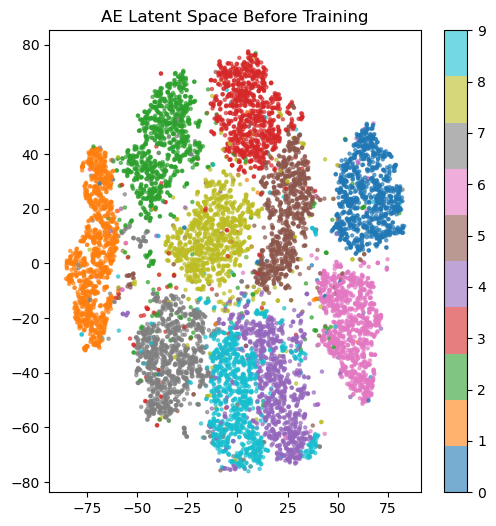

In [9]:
visualize_latent_space(ae, test_loader, title="AE Latent Space Before Training")

### Train the Simple Autoencoder

In [10]:
num_epochs = 5

ae.train()
losses_ae = []

for epoch in range(num_epochs):
    epoch_loss = 0.0
    for images, _ in tqdm(train_loader, desc=f"Epoch {epoch+1}/{num_epochs}", leave=False):
        images = images.to(device)
        
        optimizer.zero_grad()
        outputs = ae(images)
        loss = criterion(outputs, images)
        loss.backward()
        optimizer.step()
        
        epoch_loss += loss.item()
    epoch_loss /= len(train_loader)
    losses_ae.append(epoch_loss)
    print(f"[Epoch {epoch+1}] Loss: {epoch_loss:.4f}")

Epoch 1/5:   0%|          | 0/937 [00:00<?, ?it/s]

[Epoch 1] Loss: 0.0103


Epoch 2/5:   0%|          | 0/937 [00:00<?, ?it/s]

[Epoch 2] Loss: 0.0034


Epoch 3/5:   0%|          | 0/937 [00:00<?, ?it/s]

[Epoch 3] Loss: 0.0026


Epoch 4/5:   0%|          | 0/937 [00:00<?, ?it/s]

[Epoch 4] Loss: 0.0023


Epoch 5/5:   0%|          | 0/937 [00:00<?, ?it/s]

[Epoch 5] Loss: 0.0021


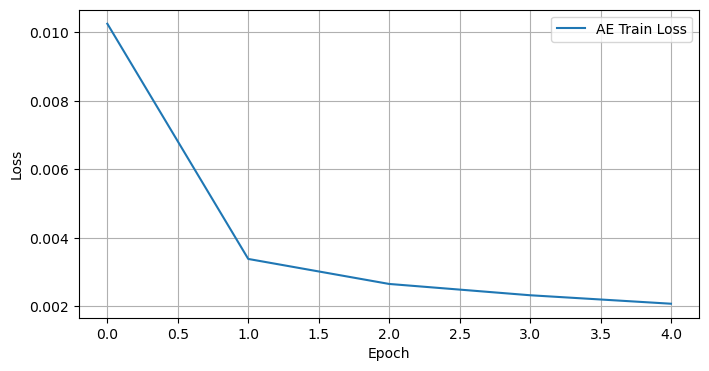

In [11]:
plt.figure(figsize=(8,4))
plt.plot(losses_ae, label="AE Train Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.grid()
plt.show()

### Post-training Visualization of Latent Space

Extracting latents:   0%|          | 0/156 [00:00<?, ?it/s]

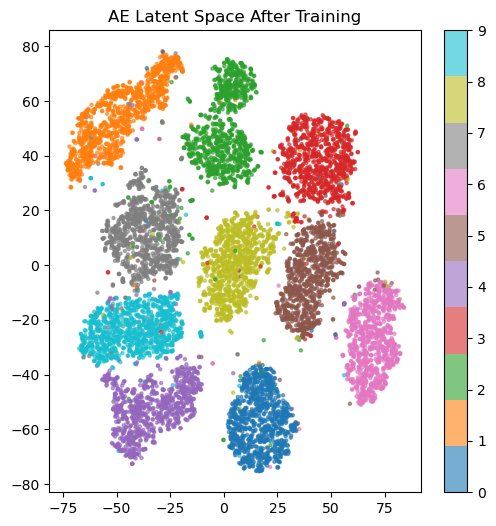

In [12]:
visualize_latent_space(ae, test_loader, title="AE Latent Space After Training")

### Qualitative Evaluation

Let's sample a batch from the **test** set and visualize:
1. The original MNIST digit
2. The Autoencoder reconstruction

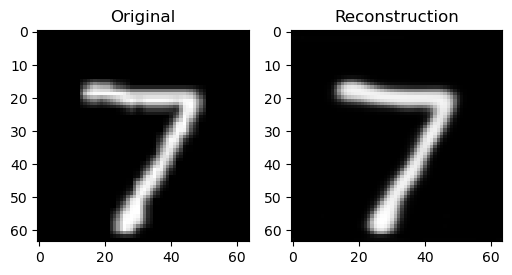

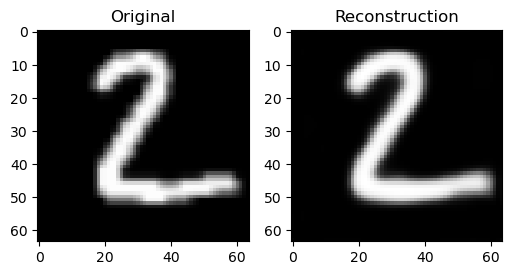

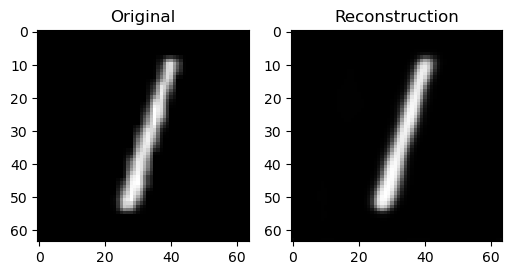

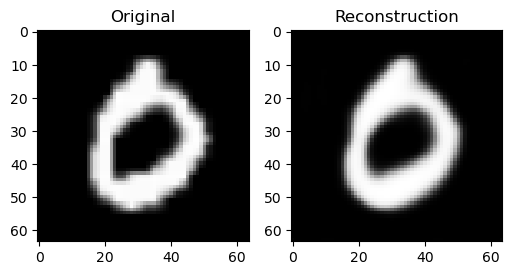

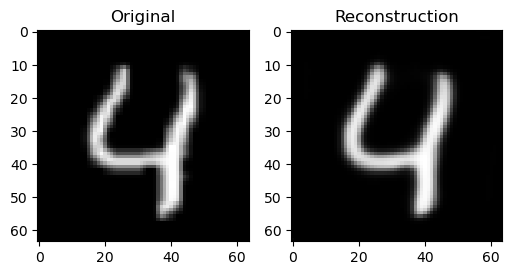

In [13]:
ae.eval()

test_batch = next(iter(test_loader))
test_images = test_batch[0].to(device)

with torch.no_grad():
    reconstructions = ae(test_images)

num_show = 5
for i in range(num_show):
    plt.figure(figsize=(6,3))
    plt.subplot(1,2,1)
    plt.title("Original")
    plt.imshow(test_images[i].squeeze().cpu(), cmap='gray')
    plt.subplot(1,2,2)
    plt.title("Reconstruction")
    plt.imshow(reconstructions[i].squeeze().cpu(), cmap='gray')
    plt.show()

In [14]:
def interpolate_latent_space(model, img1, img2, steps=8):
    model.eval()
    with torch.no_grad():
        z1 = model.get_latent_features(img1.unsqueeze(0).to(device))  # e.g. shape [1, 32, 4, 4]
        z2 = model.get_latent_features(img2.unsqueeze(0).to(device))  # same shape

        interpolations = []
        for alpha in np.linspace(0, 1, steps):
            z_int = (1 - alpha) * z1 + alpha * z2
            x_hat = model.decoder(z_int)
            x_hat = torch.sigmoid(x_hat).cpu()  
            # remove the first (batch) dimension for plotting
            interpolations.append(x_hat.squeeze(0).numpy())

    fig, axes = plt.subplots(1, steps, figsize=(steps * 2, 2))
    for i, ax in enumerate(axes):
        ax.imshow(interpolations[i].squeeze(), cmap='gray')
        ax.axis('off')
    plt.suptitle("Latent Space Interpolation", fontsize=14)
    plt.show()

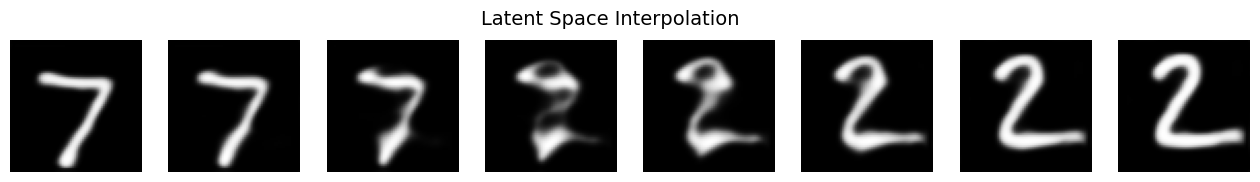

In [15]:
sample_batch = next(iter(test_loader))
img1, img2 = sample_batch[0][0], sample_batch[0][1]
interpolate_latent_space(ae, img1, img2, steps=8)

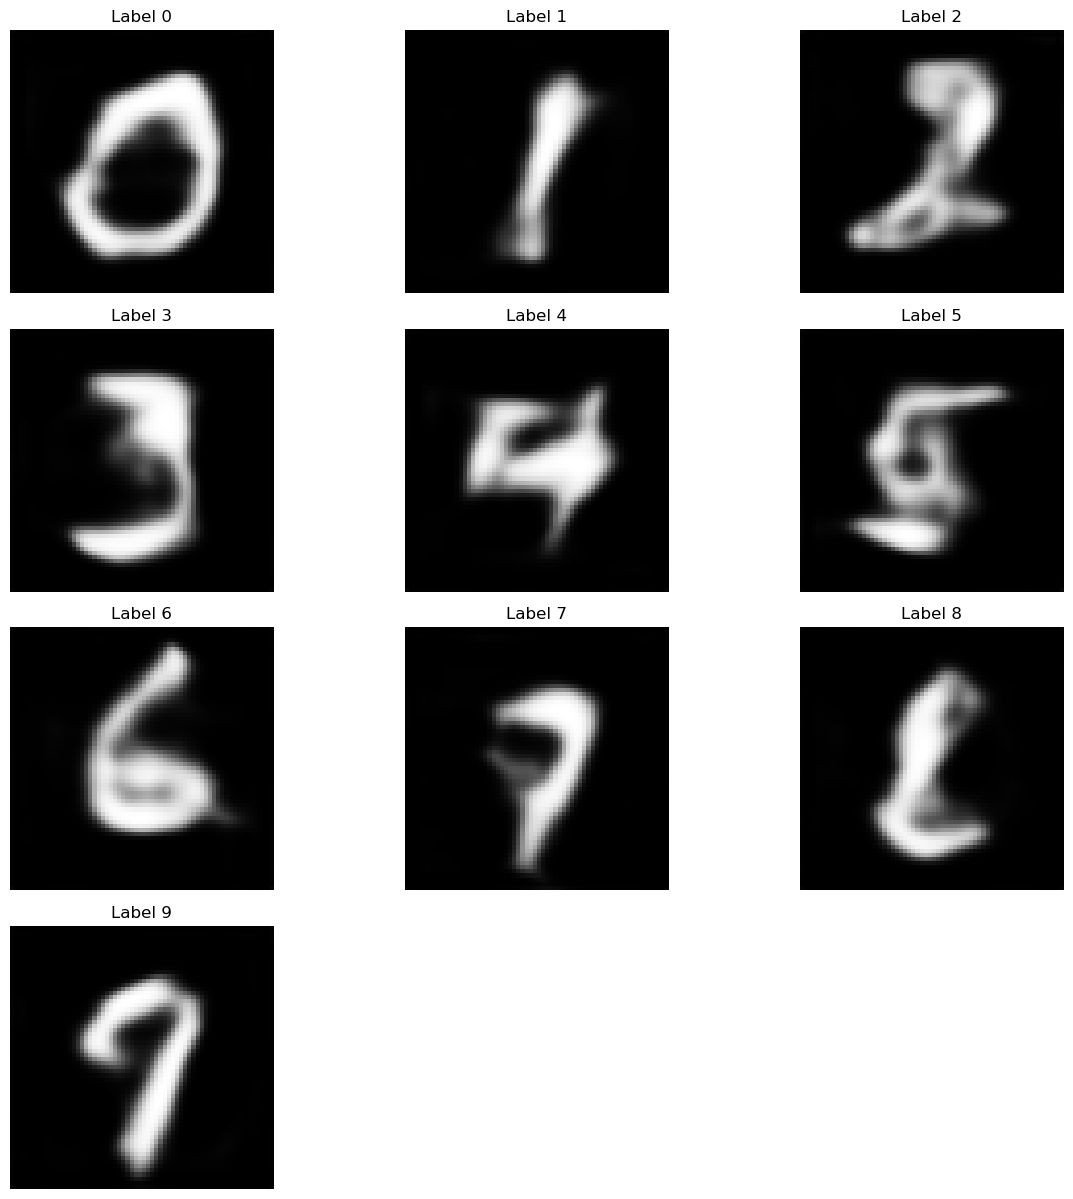

In [16]:
def compute_activation_stats(train_loader, model, device='cpu'):
    """
    Collects activations for each label and computes mean and std without flattening the hidden space.

    Args:
        train_loader (DataLoader): DataLoader containing the training data.
        model (nn.Module): Trained model with an encoder.

    Returns:
        dict: Dictionary containing activation statistics (mean, std) for each label.
    """
    from collections import defaultdict
    model.eval()
    activations = defaultdict(list)

    # Collect activations
    with torch.no_grad():
        for x, y in train_loader:
            x = x.to(device)
            latent = model.get_latent_features(x)  # Retain original shape (e.g., [batch_size, 32, 4, 4])
            for i, label in enumerate(y):
                activations[label.item()].append(latent[i].cpu())

    # Compute statistics
    stats = {}
    for label, act_list in activations.items():
        all_acts = torch.stack(act_list, dim=0)  # Stack activations (e.g., [num_samples, 32, 4, 4])
        mean = all_acts.mean(dim=0)
        std = all_acts.std(dim=0)
        stats[label] = {'mean': mean, 'std': std}

    return stats

def sample_from_statistics(stats):
    """
    Samples from normal distributions defined by the given statistics.

    Args:
        stats (dict): Dictionary containing mean and std for each label.

    Returns:
        dict: Samples for each label drawn from normal distribution.
    """
    samples = {}
    for label, stat in stats.items():
        mean, std = stat['mean'], stat['std']
        samples[label] = torch.normal(mean=mean, std=std)
    return samples

def plot_samples(samples, decoder, device='cpu'):
    """
    Decodes sampled latent representations using the decoder and plots the results.

    Args:
        samples (dict): Dictionary containing sampled latent representations for each label.
        decoder (nn.Module): Decoder block to reconstruct images.
    """
    if isinstance(decoder, nn.Module):
        decoder.eval()
    sorted_labels = sorted(samples.keys())
    plt.figure(figsize=(12, len(sorted_labels) * 3))

    for i, label in enumerate(sorted_labels):
        sample = samples[label]
        sample_tensor = sample.to(device).unsqueeze(0)  # Add batch dimension
        with torch.no_grad():
            decoded_image = decoder(sample_tensor)
            decoded_image = torch.sigmoid(decoded_image).squeeze().cpu().numpy()

        # Plot the decoded image
        plt.subplot(len(sorted_labels), 3, i + 1)
        plt.title(f"Label {label}")
        plt.imshow(decoded_image, cmap='gray')
        plt.axis("off")

    plt.tight_layout()
    plt.show()


stats = compute_activation_stats(train_loader, ae, device=device)
samples = sample_from_statistics(stats)
plot_samples(samples, decoder=ae.decoder, device=device)


# 2. Denoising Autoencoder (DAE)

**Key Idea**: Instead of reconstructing the clean input directly, we **corrupt** the input with noise and then learn to reconstruct the original clean input. This helps the network learn more robust features.

![](https://miro.medium.com/v2/1*_wEd8y0cx1ASHqz4gzQ_kA.png)

In [17]:
def add_noise(x, noise_factor=0.1):
    """
    Adds random Gaussian noise to input images.
    """
    return x + noise_factor * torch.randn_like(x)

class DenoisingBlock(nn.Module):
    """
    Similar to Block, but adds dropout and optional noise within the forward pass.
    """
    def __init__(self, in_features, out_features, kernel=3, stride=1, bias=False, upsample=False, dropout_p=0.3):
        super().__init__()
        self.upsample = upsample
        self.conv = nn.Conv2d(in_features, out_features, kernel, stride=stride, 
                              padding=(kernel - 1) // 2, bias=bias)
        self.norm = nn.BatchNorm2d(out_features)
        self.act = nn.LeakyReLU(0.2)
        self.dropout = nn.Dropout2d(dropout_p)

    def forward(self, x):
        if self.upsample:
            x = F.interpolate(
                x, scale_factor=2, mode='bilinear', align_corners=False
            )
        x = self.conv(x)
        x = self.norm(x)
        x = self.act(x)
        x = self.dropout(x)
        return x

class DenoisingAutoEncoder(nn.Module):
    """
    Convolutional Denoising Autoencoder.
    """
    def __init__(self):
        super().__init__()
        self.encoder = nn.Sequential(
            DenoisingBlock(1, 16, 3, stride=2),
            DenoisingBlock(16, 32, 3, stride=2),
            DenoisingBlock(32, 32, 3, stride=2),
            DenoisingBlock(32, 32, 3, stride=2),
            nn.Conv2d(32, 32, 3, padding=1)
        )
        
        self.decoder = nn.Sequential(
            DenoisingBlock(32, 32, 3, upsample=True),
            DenoisingBlock(32, 32, 3, upsample=True),
            DenoisingBlock(32, 32, 3, upsample=True),
            DenoisingBlock(32, 16, 3, upsample=True),
            nn.Conv2d(16, 1, 3, padding=1)
        )

    def forward(self, x):
        z = self.encoder(x)
        out = self.decoder(z)
        out = torch.sigmoid(out)
        return out
    
    def get_latent_features(self, x):
        return self.encoder(x)

### Train the Denoising Autoencoder

We apply noise to the input images, but the target remains the **clean** image. We'll keep using the same MSELoss, though BCE can also be used.

In [18]:
dae = DenoisingAutoEncoder().to(device)
optimizer_dae = torch.optim.Adam(dae.parameters(), lr=learning_rate)
criterion_dae = nn.MSELoss()

Extracting latents:   0%|          | 0/156 [00:00<?, ?it/s]

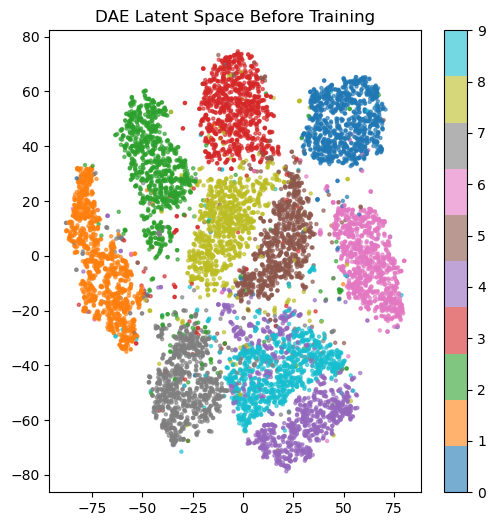

In [19]:
visualize_latent_space(dae, test_loader, title="DAE Latent Space Before Training")

In [20]:
dae.train()
losses_dae = []

for epoch in range(num_epochs):
    epoch_loss = 0.0
    for images, _ in tqdm(train_loader, desc=f"DAE Epoch {epoch+1}/{num_epochs}", leave=False):
        images_noisy = add_noise(images, noise_factor=0.2).to(device)
        images = images.to(device)
        
        optimizer_dae.zero_grad()
        outputs = dae(images_noisy)
        loss = criterion_dae(outputs, images)
        loss.backward()
        optimizer_dae.step()
        
        epoch_loss += loss.item()
    epoch_loss /= len(train_loader)
    losses_dae.append(epoch_loss)
    print(f"[DAE Epoch {epoch+1}] Loss: {epoch_loss:.4f}")

DAE Epoch 1/5:   0%|          | 0/937 [00:00<?, ?it/s]

[DAE Epoch 1] Loss: 0.0313


DAE Epoch 2/5:   0%|          | 0/937 [00:00<?, ?it/s]

[DAE Epoch 2] Loss: 0.0137


DAE Epoch 3/5:   0%|          | 0/937 [00:00<?, ?it/s]

[DAE Epoch 3] Loss: 0.0116


DAE Epoch 4/5:   0%|          | 0/937 [00:00<?, ?it/s]

[DAE Epoch 4] Loss: 0.0107


DAE Epoch 5/5:   0%|          | 0/937 [00:00<?, ?it/s]

[DAE Epoch 5] Loss: 0.0102


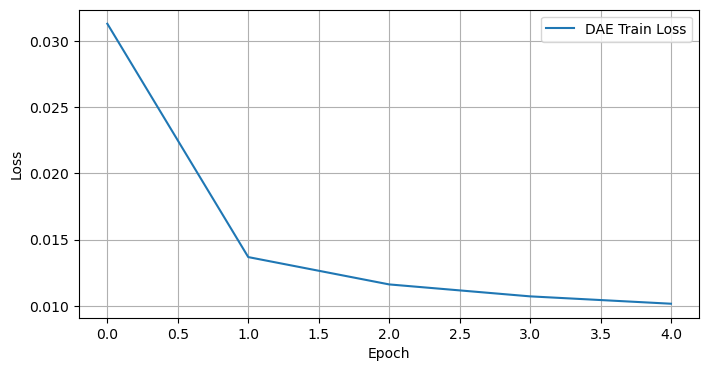

In [21]:
plt.figure(figsize=(8,4))
plt.plot(losses_dae, label="DAE Train Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.grid()
plt.show()

Extracting latents:   0%|          | 0/156 [00:00<?, ?it/s]

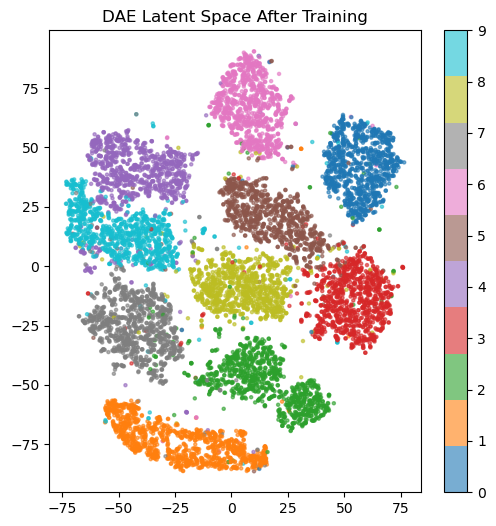

In [22]:
visualize_latent_space(dae, test_loader, title="DAE Latent Space After Training")

### Visualize Denoising Effect

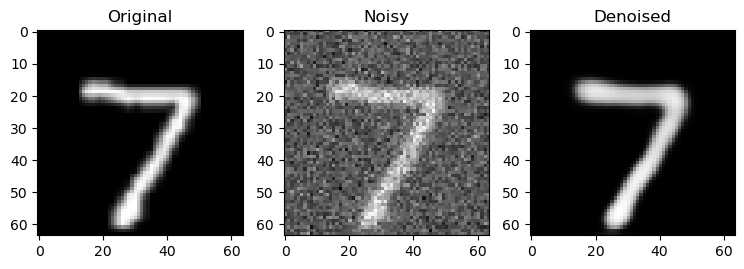

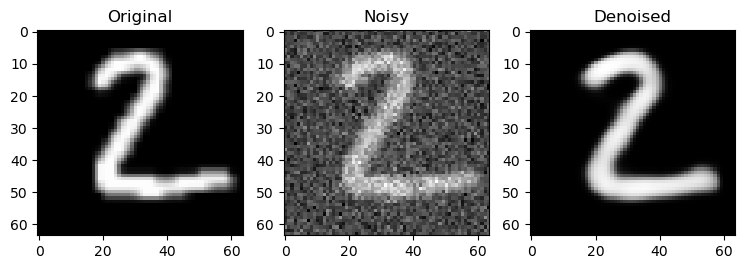

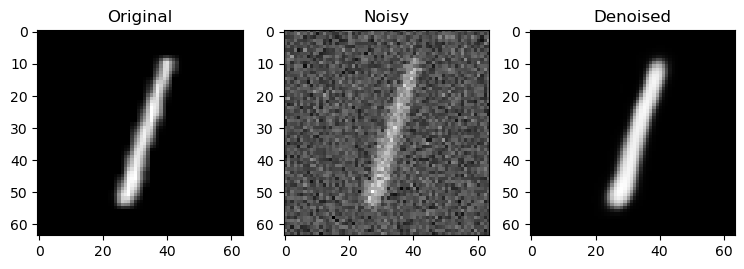

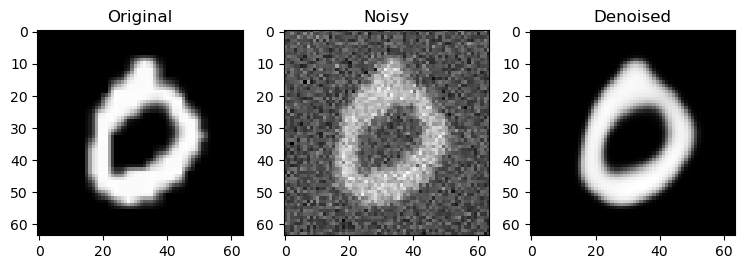

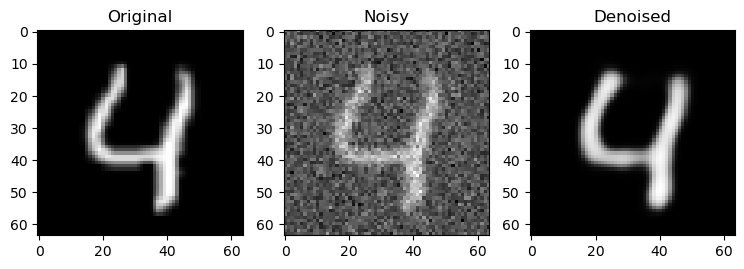

In [23]:
dae.eval()
test_batch = next(iter(test_loader))
test_images = test_batch[0].to(device)
test_noisy = add_noise(test_images, noise_factor=0.2)

with torch.no_grad():
    denoised = dae(test_noisy)

num_show = 5
for i in range(num_show):
    plt.figure(figsize=(9,3))
    plt.subplot(1,3,1)
    plt.title("Original")
    plt.imshow(test_images[i].squeeze().cpu(), cmap='gray')
    
    plt.subplot(1,3,2)
    plt.title("Noisy")
    plt.imshow(test_noisy[i].squeeze().cpu(), cmap='gray')
    
    plt.subplot(1,3,3)
    plt.title("Denoised")
    plt.imshow(denoised[i].squeeze().cpu(), cmap='gray')
    plt.show()

### Sampling from DAE

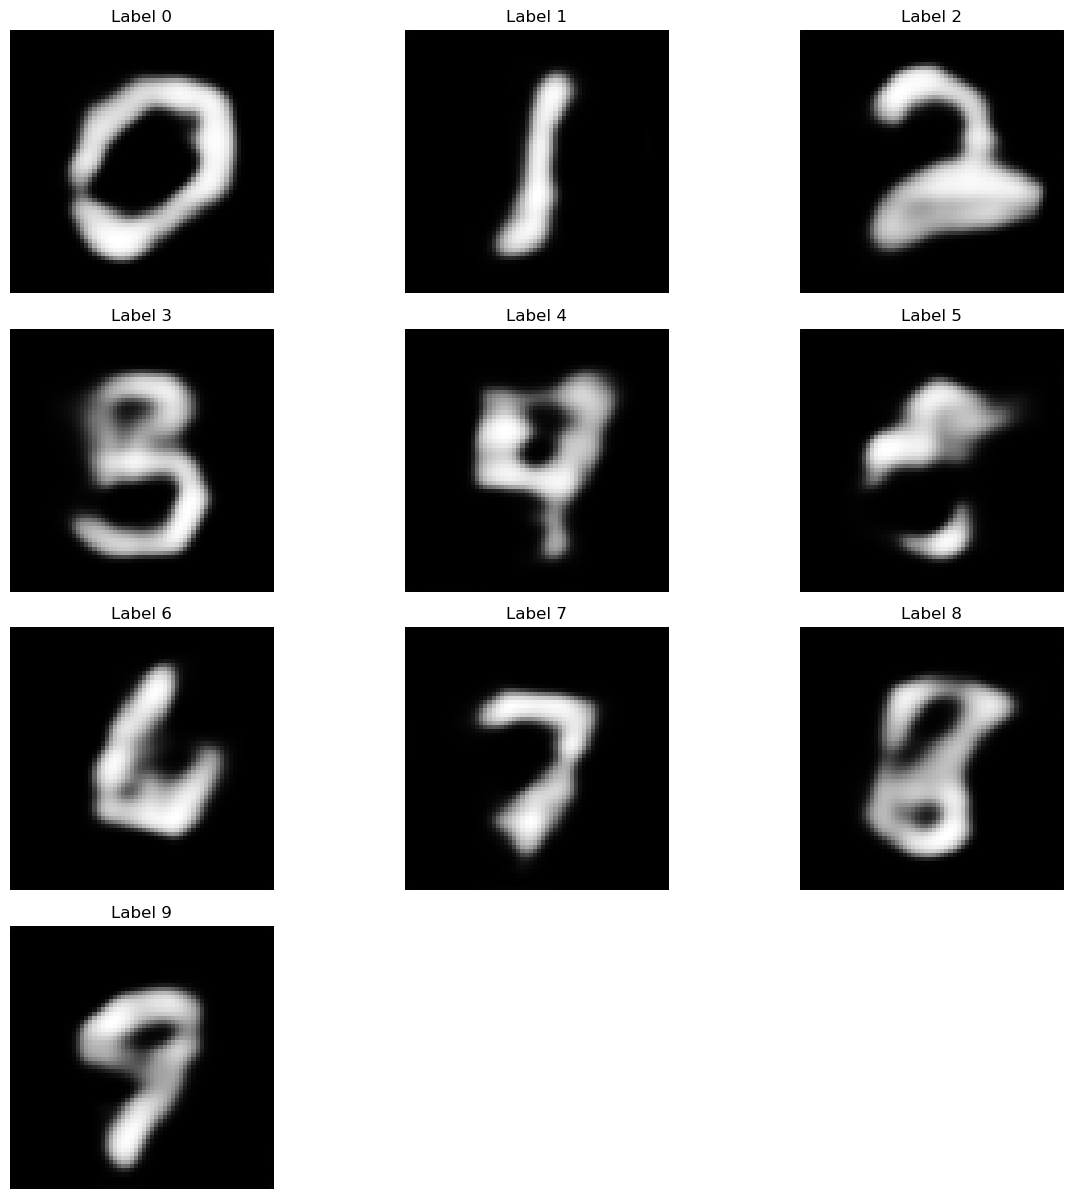

In [24]:
stats = compute_activation_stats(train_loader, dae, device=device)
samples = sample_from_statistics(stats)
plot_samples(samples, decoder=dae.decoder, device=device)

# 3. Sparse Autoencoder

**Key Idea**: We add a term in the loss function to encourage sparsity in the latent representation. 

**Two Common Approaches**:
1. KL Divergence regularization on the activation distributions.
2. L1 regularization on the latent layer outputs.

Encouraging **sparsity** can make the model learn more distinct (localized) features. 

| ![https://www.jeremyjordan.me/autoencoders/](https://www.jeremyjordan.me/content/images/2018/03/Screen-Shot-2018-03-07-at-1.50.55-PM.png) | 
|:--:| 
| The opacity of a node corresponds with the level of activation. *https://www.jeremyjordan.me/autoencoders/* |

In [25]:
def kl_divergence_activations(x, p=0.05):
    """
    KL Divergence term encouraging the average activation of x to be p.
    x is assumed to be in [0,1] after a sigmoid or similar.
    """
    x_mean = torch.mean(x, dim=0)
    p_tensor = torch.ones_like(x_mean) * p
    kl = p_tensor * torch.log(p_tensor / x_mean) + \
         (1 - p_tensor) * torch.log((1 - p_tensor) / (1 - x_mean))
    return torch.sum(kl)

## Sparse AE with KL Divergence

Here is an example implementing the KL approach at **intermediate** layers. The code shows how you can accumulate KL divergence across all layers.

In [ ]:
class SparseAE_KL(nn.Module):
    """
    Sparse Autoencoder with KL divergence on hidden layer activations.
    We'll keep the architecture similar to our first simple AE.
    """
    def __init__(self, p=0.05, beta=0.001):
        super().__init__()
        self.p = p
        self.beta = beta
        
        self.enc_conv1 = nn.Conv2d(1, 16, 3, stride=2, padding=1)
        self.enc_bn1 = nn.BatchNorm2d(16)
        self.enc_conv2 = nn.Conv2d(16, 32, 3, stride=2, padding=1)
        self.enc_bn2 = nn.BatchNorm2d(32)
        self.enc_conv3 = nn.Conv2d(32, 32, 3, stride=2, padding=1)
        self.enc_bn3 = nn.BatchNorm2d(32)
        self.enc_conv4 = nn.Conv2d(32, 32, 3, stride=2, padding=1)
        self.enc_bn4 = nn.BatchNorm2d(32)
        self.enc_conv5 = nn.Conv2d(32, 32, 3, padding=1)
        
        self.dec_up1 = nn.ConvTranspose2d(32, 32, 4, stride=2, padding=1)
        self.dec_bn1 = nn.BatchNorm2d(32)
        self.dec_up2 = nn.ConvTranspose2d(32, 32, 4, stride=2, padding=1)
        self.dec_bn2 = nn.BatchNorm2d(32)
        self.dec_up3 = nn.ConvTranspose2d(32, 32, 4, stride=2, padding=1)
        self.dec_bn3 = nn.BatchNorm2d(32)
        self.dec_up4 = nn.ConvTranspose2d(32, 16, 4, stride=2, padding=1)
        self.dec_bn4 = nn.BatchNorm2d(16)
        self.dec_conv5 = nn.Conv2d(16, 1, 3, padding=1)
        
    def encoder_forward(self, x):
        """
        Return intermediate activations for computing KL divergence.
        We'll apply a sigmoid after each batch norm to keep values in [0,1].
        """
        h1 = torch.sigmoid(self.enc_bn1(self.enc_conv1(x)))
        h2 = torch.sigmoid(self.enc_bn2(self.enc_conv2(h1)))
        h3 = torch.sigmoid(self.enc_bn3(self.enc_conv3(h2)))
        h4 = torch.sigmoid(self.enc_bn4(self.enc_conv4(h3)))
        h5 = self.enc_conv5(h4)
        return [h1, h2, h3, h4], h5

    def decoder_forward(self, z):
        d1 = torch.sigmoid(self.dec_bn1(self.dec_up1(z)))
        d2 = torch.sigmoid(self.dec_bn2(self.dec_up2(d1)))
        d3 = torch.sigmoid(self.dec_bn3(self.dec_up3(d2)))
        d4 = torch.sigmoid(self.dec_bn4(self.dec_up4(d3)))
        d5 = self.dec_conv5(d4)
        return d5

    def forward(self, x):
        h_list, h5_raw = self.encoder_forward(x)
        h5 = torch.sigmoid(h5_raw)
        
        d_raw = self.decoder_forward(h5)
        out = torch.sigmoid(d_raw)
        return out
    
    def get_latent_features(self, x):
        """
        Return the final encoder features (the 'h5' after sigmoid).
        """
        _, h5_raw = self.encoder_forward(x)
        return torch.sigmoid(h5_raw)

    def kl_loss_all_layers(self, h_list):
        """
        Summation of KL loss over intermediate layers. 
        """
        kl_sum = 0
        for h in h_list:
            kl_sum += kl_divergence_activations(h, p=self.p)
        return kl_sum * self.beta

### Training Sparse AE (KL-based)

We add $\beta \times \mathrm{KL}$ to the reconstruction loss.

In [27]:
sparse_ae_kl = SparseAE_KL(p=0.05, beta=0.001).to(device)
optimizer_sae_kl = torch.optim.Adam(sparse_ae_kl.parameters(), lr=learning_rate)
criterion_sae_kl = nn.MSELoss()

sparse_ae_kl.train()
losses_sae_kl = []

for epoch in range(num_epochs):
    epoch_loss = 0.0
    for images, _ in tqdm(train_loader, desc=f"SAE-KL Epoch {epoch+1}/{num_epochs}", leave=False):
        images = images.to(device)
        
        optimizer_sae_kl.zero_grad()
        out = sparse_ae_kl(images)
        
        # Get intermediate layers
        h_list, _ = sparse_ae_kl.encoder_forward(images)
        
        # Recon loss
        recon_loss = criterion_sae_kl(out, images)
        # KL loss
        kl_loss_val = sparse_ae_kl.kl_loss_all_layers(h_list)
        
        loss = recon_loss + kl_loss_val
        loss.backward()
        optimizer_sae_kl.step()
        
        epoch_loss += loss.item()
    epoch_loss /= len(train_loader)
    losses_sae_kl.append(epoch_loss)
    print(f"[SAE-KL Epoch {epoch+1}] Loss: {epoch_loss:.4f}")

SAE-KL Epoch 1/5:   0%|          | 0/937 [00:00<?, ?it/s]

[SAE-KL Epoch 1] Loss: 8.8531


SAE-KL Epoch 2/5:   0%|          | 0/937 [00:00<?, ?it/s]

[SAE-KL Epoch 2] Loss: 4.4430


SAE-KL Epoch 3/5:   0%|          | 0/937 [00:00<?, ?it/s]

[SAE-KL Epoch 3] Loss: 2.3315


SAE-KL Epoch 4/5:   0%|          | 0/937 [00:00<?, ?it/s]

[SAE-KL Epoch 4] Loss: 0.7877


SAE-KL Epoch 5/5:   0%|          | 0/937 [00:00<?, ?it/s]

[SAE-KL Epoch 5] Loss: 0.2141


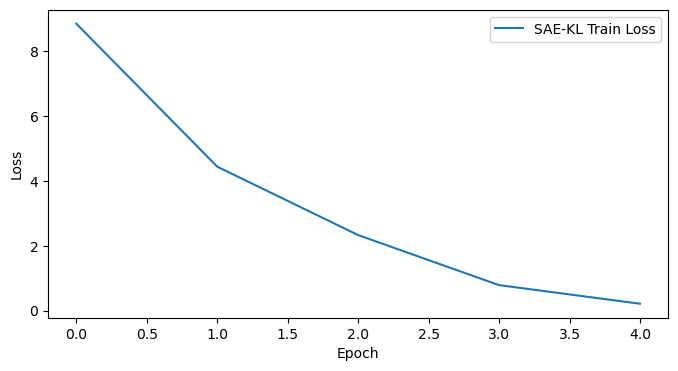

In [28]:
plt.figure(figsize=(8,4))
plt.plot(losses_sae_kl, label="SAE-KL Train Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.show()

### Visualization

Extracting latents:   0%|          | 0/156 [00:00<?, ?it/s]

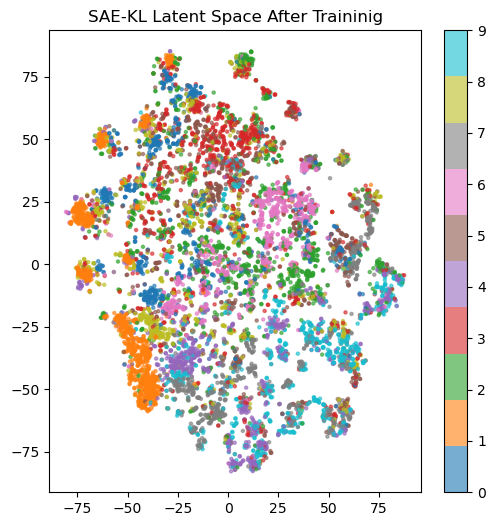

In [29]:
visualize_latent_space(sparse_ae_kl, test_loader, title="SAE-KL Latent Space After Traininig")

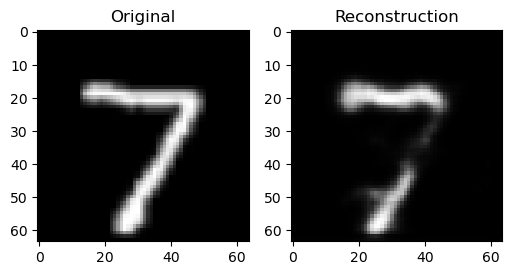

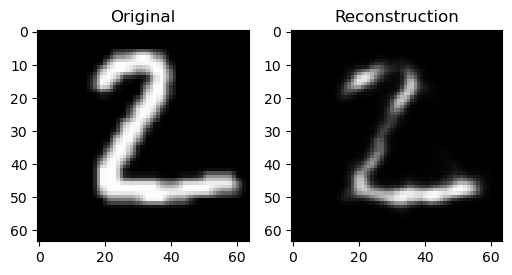

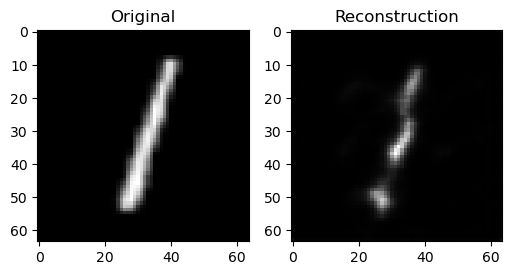

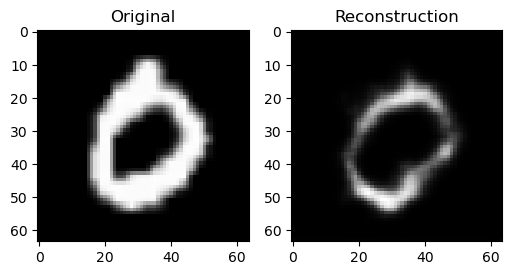

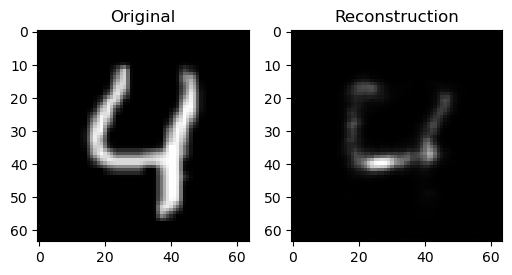

In [30]:
sparse_ae_kl.eval()
test_batch = next(iter(test_loader))
test_images = test_batch[0].to(device)

with torch.no_grad():
    recon = sparse_ae_kl(test_images)

num_show = 5
for i in range(num_show):
    plt.figure(figsize=(6,3))
    plt.subplot(1,2,1)
    plt.title("Original")
    plt.imshow(test_images[i].squeeze().cpu(), cmap='gray')
    plt.subplot(1,2,2)
    plt.title("Reconstruction")
    plt.imshow(recon[i].squeeze().cpu(), cmap='gray')
    plt.show()

### Sampling from SAE-KL

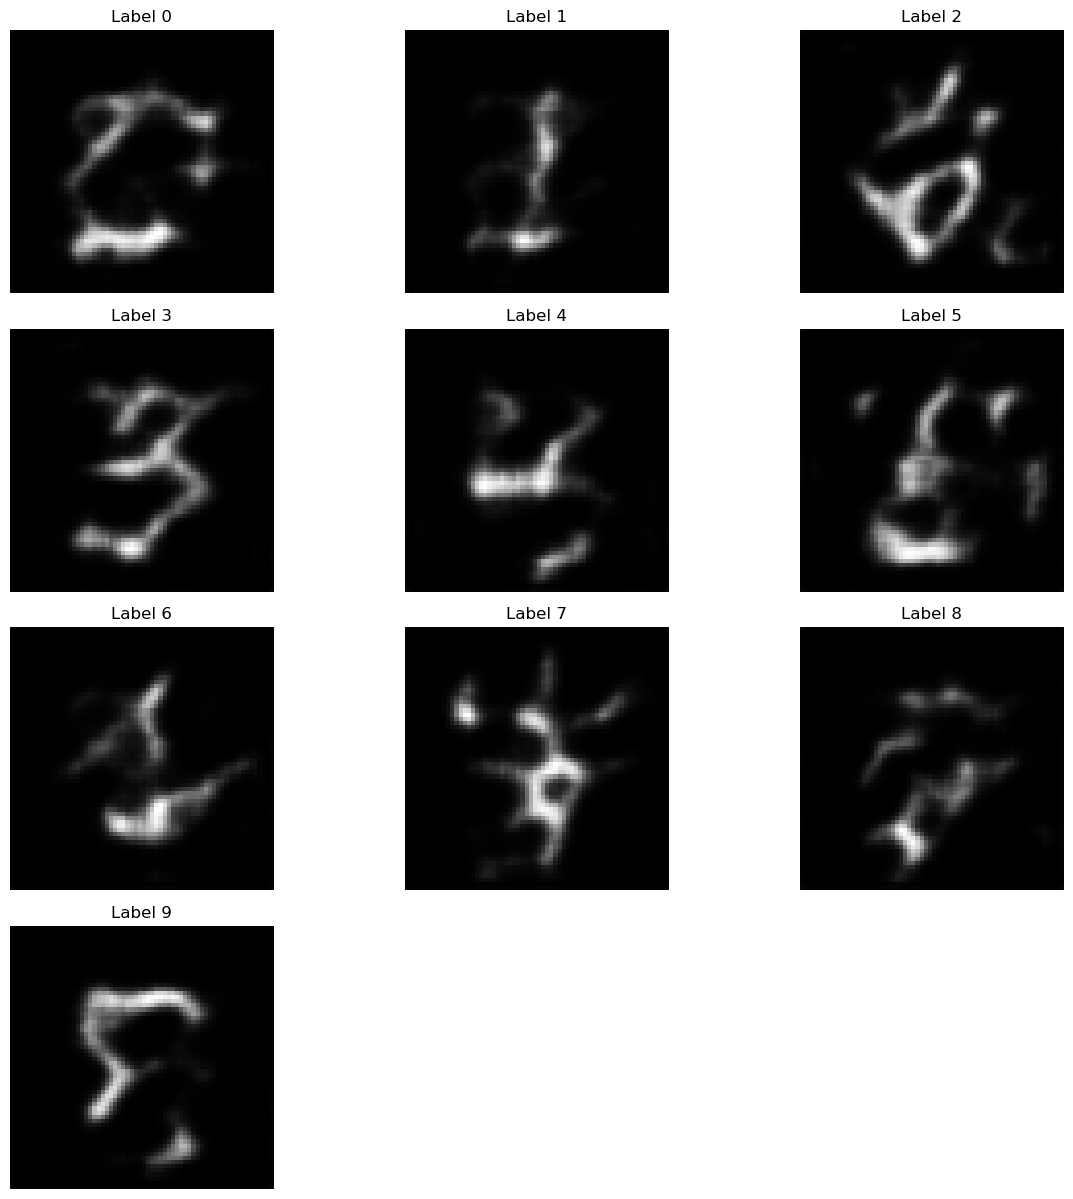

In [31]:
stats = compute_activation_stats(train_loader, sparse_ae_kl, device=device)
samples = sample_from_statistics(stats)
plot_samples(samples, decoder=sparse_ae_kl.decoder_forward, device=device)

## Sparse AE with L1 Penalty

Another simpler approach is to apply L1 regularization on the latent features to push them towards zero.

In [32]:
class SparseAE_L1(nn.Module):
    """
    Sparse Autoencoder with L1 penalty on the bottleneck.
    """
    def __init__(self):
        super().__init__()
        self.encoder = nn.Sequential(
            Block(1,   16, 3, stride=2),
            Block(16,  32, 3, stride=2),
            Block(32,  32, 3, stride=2),
            Block(32,  32, 3, stride=2),
            nn.Conv2d(32, 32, 3, padding=1)
        )
        self.decoder = nn.Sequential(
            Block(32, 32, 3, upsample=True),
            Block(32, 32, 3, upsample=True),
            Block(32, 32, 3, upsample=True),
            Block(32, 16, 3, upsample=True),
            nn.Conv2d(16, 1, 3, padding=1)
        )

    def forward(self, x):
        z = self.encoder(x)
        out = self.decoder(z)
        out = torch.sigmoid(out)
        return out
    
    def get_latent_features(self, x):
        return self.encoder(x)

    def l1_regularization(self, z):
        """
        Apply L1 norm to the bottleneck feature maps.
        """
        return torch.mean(torch.abs(z))

In [33]:
sparse_ae_l1 = SparseAE_L1().to(device)
optimizer_sae_l1 = torch.optim.Adam(sparse_ae_l1.parameters(), lr=learning_rate)
criterion_sae_l1 = nn.MSELoss()
l1_lambda = 0.001  # Regularization coefficient

In [34]:
sparse_ae_l1.train()
losses_sae_l1 = []

for epoch in range(num_epochs):
    epoch_loss = 0.0
    for images, _ in tqdm(train_loader, desc=f"SAE-L1 Epoch {epoch+1}/{num_epochs}", leave=False):
        images = images.to(device)
        
        optimizer_sae_l1.zero_grad()
        outputs = sparse_ae_l1(images)
        
        # Reconstruction loss
        recon_loss = criterion_sae_l1(outputs, images)
        # L1 penalty on the bottleneck
        z = sparse_ae_l1.get_latent_features(images)
        l1_loss_val = sparse_ae_l1.l1_regularization(z)
        
        loss = recon_loss + l1_lambda * l1_loss_val
        loss.backward()
        optimizer_sae_l1.step()
        
        epoch_loss += loss.item()
    epoch_loss /= len(train_loader)
    losses_sae_l1.append(epoch_loss)
    print(f"[SAE-L1 Epoch {epoch+1}] Loss: {epoch_loss:.4f}")

SAE-L1 Epoch 1/5:   0%|          | 0/937 [00:00<?, ?it/s]

[SAE-L1 Epoch 1] Loss: 0.0095


SAE-L1 Epoch 2/5:   0%|          | 0/937 [00:00<?, ?it/s]

[SAE-L1 Epoch 2] Loss: 0.0034


SAE-L1 Epoch 3/5:   0%|          | 0/937 [00:00<?, ?it/s]

[SAE-L1 Epoch 3] Loss: 0.0028


SAE-L1 Epoch 4/5:   0%|          | 0/937 [00:00<?, ?it/s]

[SAE-L1 Epoch 4] Loss: 0.0024


SAE-L1 Epoch 5/5:   0%|          | 0/937 [00:00<?, ?it/s]

[SAE-L1 Epoch 5] Loss: 0.0022


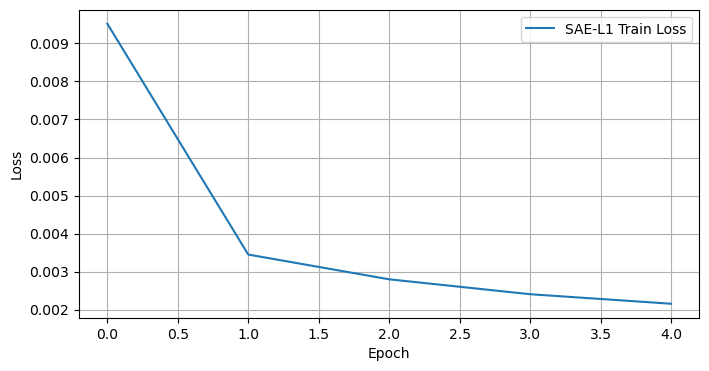

In [35]:
plt.figure(figsize=(8,4))
plt.plot(losses_sae_l1, label="SAE-L1 Train Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.grid()
plt.show()

### Visualization

Extracting latents:   0%|          | 0/156 [00:00<?, ?it/s]

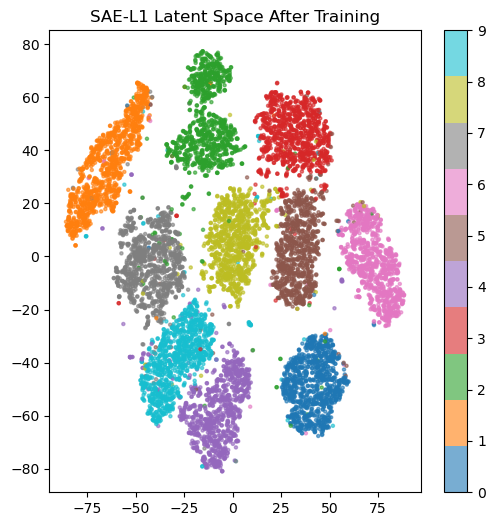

In [36]:
visualize_latent_space(sparse_ae_l1, test_loader, title="SAE-L1 Latent Space After Training")

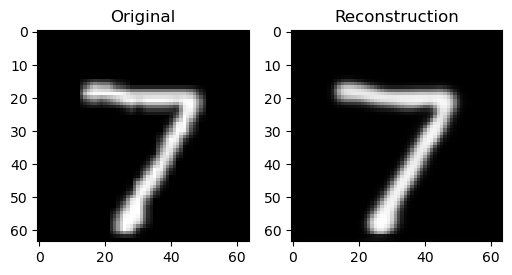

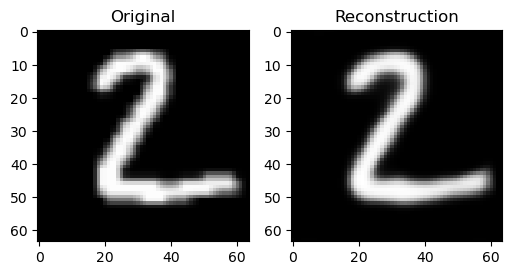

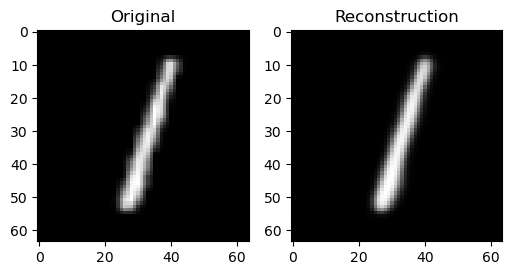

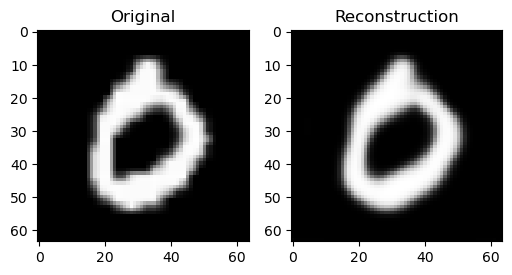

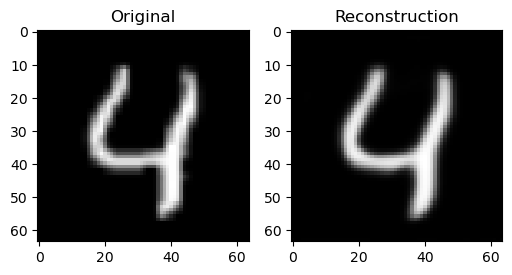

In [37]:
sparse_ae_l1.eval()
test_batch = next(iter(test_loader))
test_images = test_batch[0].to(device)

with torch.no_grad():
    recon = sparse_ae_l1(test_images)

num_show = 5
for i in range(num_show):
    plt.figure(figsize=(6,3))
    plt.subplot(1,2,1)
    plt.title("Original")
    plt.imshow(test_images[i].squeeze().cpu(), cmap='gray')
    plt.subplot(1,2,2)
    plt.title("Reconstruction")
    plt.imshow(recon[i].squeeze().cpu(), cmap='gray')
    plt.show()

### Sampling from SAE-L1

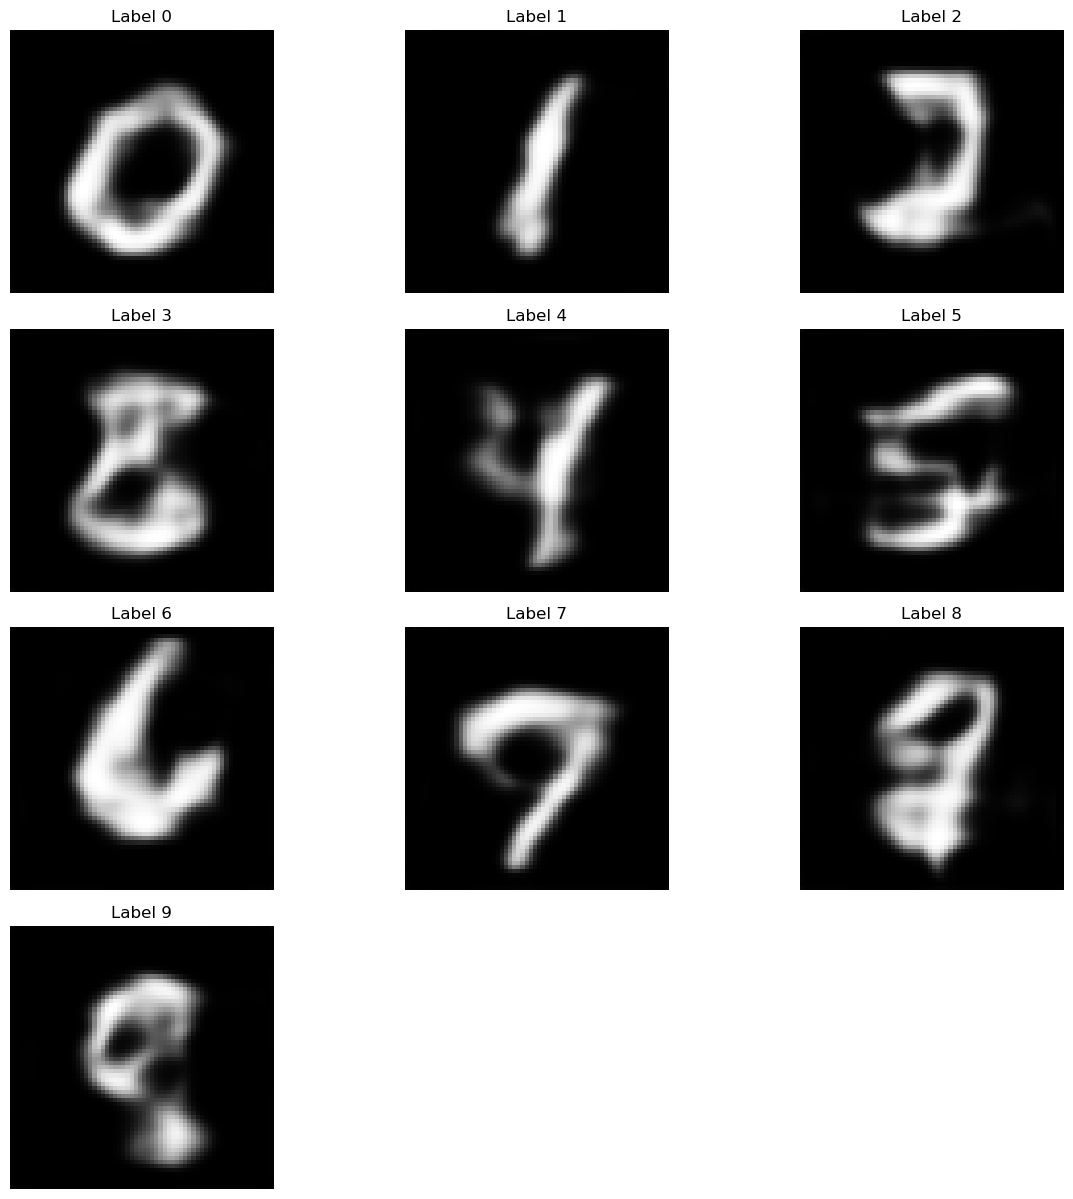

In [38]:
stats = compute_activation_stats(train_loader, sparse_ae_l1, device=device)
samples = sample_from_statistics(stats)
plot_samples(samples, decoder=sparse_ae_l1.decoder, device=device)

# Conclusion

In this first seminar notebook, we learned about:
- Building and training a **simple Autoencoder**.
- Extending it to a **Denoising Autoencoder**.
- Adding **sparsity** to the latent layer using either **KL divergence** or **L1** penalty.
- **Sampling** from the latent space